# <center>UP3, Optimization for machine learning: regression with a Neural Network from scratch </center>

This notebook contains the questions of the practical session along with complementary guidelines and examples. The code is written in Python. The questions are in red.

First import all given code. You are encouraged to have a look at forward_propagation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List

from gradient_descent import gradient_descent
from optim_utilities import print_rec
from test_functions import (
    linear_function,
    ackley,
    sphere,
    quadratic,
    rosen,
    L1norm,
    sphereL1,
    rastrigin,
    michalewicz,
    schwefel
)
from restarted_gradient_descent import restarted_gradient_descent
from random_search import random_opt  # always useful to compare optim algos to a random search

from gradient_descent_patched import gradient_descent # nouveau import du descente gradient modifié
from restarted_gradient_descent_patched import restarted_gradient_descent # nouveau import du descente gradient
# auto reload to reload functions imported that have been changed (cf. test_functions.sphereL1 for lbda)
%load_ext autoreload
%autoreload 2

In [2]:
from forward_propagation import (
    forward_propagation, 
    create_weights, 
    vector_to_weights,
    weights_to_vector)
from activation_functions import (
    relu,
    sigmoid,
    linear,
    leaky_relu
) 

### Data structure behind the forward propagation

To start, let's have a look at the structure used to encode the network. Don't worry, more handy utility functions will be introduced soon to manipulate the network globally. 

The following network has 2 layers, the first going from 4 input components to the 3 internal neurons, the second going from the 3 internal neurons outputs to the 2 outputs. Don't forget the additional weight for the neurons biases.
* `weight[l][i,j]` links entry `j` to output `i` in a layer `l`
* the last column of the weights are the biases of the neurons

In [3]:
# input data
inputs = np.array([[1,2,5,4],[1,0.2,0.15,0.024],[2,1.2,-1.01,-0.4]])
# describe the neural net
weights = [
        np.array(
            [
                [1,0.2,0.5,1,-1],
                [2,1,3,5,0],
                [0.2,0.1,0.6,0.78,1]
            ]
        ),
    np.array(
            [
                [1,0.2,0.5,1],
                [2,1,3,5]
            ]
        )
    ]
activation = sigmoid
# carry out forward propagation
y=forward_propagation(inputs,weights,activation)
# reporting
print(f'This network has {inputs.shape[1]} inputs, {y.shape[1]} outputs and {inputs.shape[0]} data points')
print('The predictions are:\n',y)

This network has 4 inputs, 2 outputs and 3 data points
The predictions are:
 [[0.93695121 0.99998324]
 [0.89266103 0.99991581]
 [0.88231234 0.99982432]]


### Create a data set 
The data set is made of points sampled randomly from a function.

In [4]:
def simulate_data_target(fun: Callable,
                       n_features: int,
                       n_obs: int,
                       LB: List[float],
                       UB: List[float]) -> dict:
    
    entry_data = np.random.uniform(low= LB,high=UB,
                                   size=(n_obs, n_features))
    target = np.apply_along_axis(fun, 1, entry_data)
    
    return {"data": entry_data, "target": target}

In [5]:
used_function = linear_function
n_features = 2
n_obs = 10
LB = [-5] * n_features
UB = [5] * n_features
simulated_data = simulate_data_target(fun = used_function,n_features = n_features,n_obs=n_obs,LB=LB,UB=UB)
print('x,f(x) =\n',np.concatenate((simulated_data["data"],simulated_data["target"].reshape(n_obs,1)),axis=1)) # don't print for too large a data set

x,f(x) =
 [[ 1.19192486  2.34416644  8.88025773]
 [-1.90537596 -3.16226603 -5.22990802]
 [ 0.75951756  0.89812479  5.55576713]
 [ 0.91741635 -1.39321659  1.13098317]
 [ 3.85482933 -1.4536674   3.94749454]
 [ 2.36321579 -2.97476735 -0.58631891]
 [-1.60145271  1.79962583  4.99779896]
 [ 0.37313581  0.36911973  4.11137526]
 [ 1.34126064 -0.6279503   3.08536003]
 [-0.21395726 -0.33033204  2.12537865]]


### Make a neural network, randomly initialize its weights, propagate input data

Create a NN with 1 layer, 2 inputs, 1 output, thus 1 neuron in the layer. Propagate the data inputs through it.

In [6]:
used_network_structure = [2,1]
used_activation = leaky_relu
weights = create_weights(used_network_structure)
weights_as_vector,_ = weights_to_vector(weights)
dim = len(weights_as_vector)
print("weights=",weights)
print("nb. of NN parameters to learn, dim=",dim)

weights= [array([[-1.06450388, -0.26700601, -0.19261401]])]
nb. of NN parameters to learn, dim= 3


In [7]:
predicted_output = forward_propagation(inputs=simulated_data["data"],weights=weights,activation_functions=used_activation)

Compare the data and the prediction of the network. Of course, at this point, no training is done so they are different. They just have the same format (provided a `reshape` is done).

data vs prediction

[[ 8.88025773e+00 -2.08732918e-02]
 [-5.22990802e+00  2.68001015e+00]
 [ 5.55576713e+00 -1.24092811e-02]
 [ 1.13098317e+00 -7.97210061e-03]
 [ 3.94749454e+00 -3.90795687e-02]
 [-5.86318911e-01 -1.91398563e-02]
 [ 4.99779896e+00  1.03162770e+00]
 [ 4.11137526e+00 -6.88375711e-03]
 [ 3.08536003e+00 -1.45272466e-02]
 [ 2.12537865e+00  1.23344973e-01]]


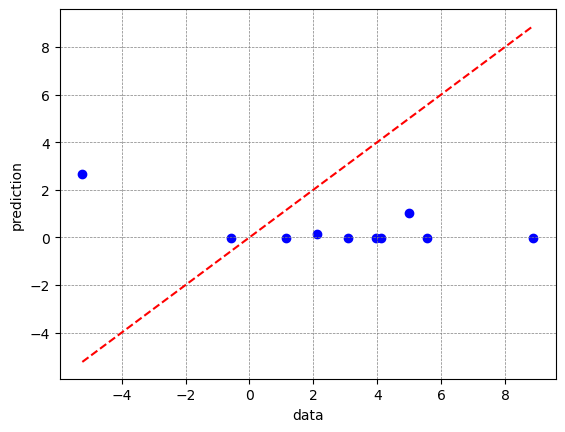

In [8]:
print("data vs prediction\n")
print(np.append(simulated_data["target"].reshape(-1,1),predicted_output,axis=1))
plt.scatter(simulated_data["target"], predicted_output, label='pred vs. data', color='blue')
min_value = simulated_data["target"].min()
max_value = simulated_data["target"].max()
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='')
plt.xlabel('data')
plt.ylabel('prediction')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

## Error functions 

Utility functions to transform weights into a vector and vice versa. This is used in the calculation of the error function (the vector is transformed into NN weights, ...).

In [9]:
# play with weight transformation functions
weights = create_weights(used_network_structure)
print('weights=\n',weights)
weights_as_vector, _ = weights_to_vector(weights)
print('weights_as_vector=\n',weights_as_vector)
w2 = vector_to_weights(weights_as_vector, used_network_structure)
print('weights back=\n',w2)

weights=
 [array([[ 0.50550426, -0.34124909,  1.15511256]])]
weights_as_vector=
 [ 0.50550426 -0.34124909  1.15511256]
weights back=
 [array([[ 0.50550426, -0.34124909,  1.15511256]])]


We define 2 error functions, one for regression is the mean square error, the other is the cross-entropy error for classification.

In [10]:
# mean squared error
def cost_function_mse(y_predicted: np.ndarray,y_observed: np.ndarray):
    error = 0.5 * np.mean((y_predicted - y_observed)**2)
    return error

In [11]:
# entropy
def cost_function_entropy(y_predicted: np.ndarray,y_observed: np.ndarray):
    n = len(y_observed) 
    term_A = np.multiply(np.log(y_predicted),y_observed)
    term_B = np.multiply(1-y_observed,np.log(1-y_predicted))  
    error = - (1/n)*(np.sum(term_A)+np.sum(term_B))
    return(error)

In [12]:
def error_with_parameters(vector_weights: np.ndarray,
                          network_structure: List[int],
                          activation_function: Callable,
                          data: dict,
                          cost_function: Callable,
                          regularization: float = 0) -> float:
    
    weights = vector_to_weights(vector_weights,network_structure)
    predicted_output = forward_propagation(data["data"],weights,activation_function)
    predicted_output = predicted_output.reshape(-1,)
    
    error = cost_function(predicted_output,data["target"]) + regularization * np.sum(np.abs(vector_weights))
    
    return error

In [13]:
# used_network_structure and used_activation defined above
used_data = simulated_data
used_cost_function = cost_function_mse


def neural_network_cost(vector_weights):
    
    cost = error_with_parameters(vector_weights,
                                 network_structure = used_network_structure,
                                 activation_function = used_activation,
                                 data = used_data,
                                 cost_function = used_cost_function)
    
    return cost

Below, the cost function associated to the neural network is calculated from a simple vector in a manner similar to $f(x)$, therefore prone to optimization. The translation of the vector into as many weight matrices as necessary is done thanks to the 
* `used_network_structure`,
* `used_activation`,
* `used_data` and
* `used_cost_function`
defined above and passed implicitely thanks to Python's scoping rules.

In [14]:
# call to the NN cost at a random point = random initialization of the weights and biases
random_weights_as_vect = np.random.uniform(size=dim)
neural_network_cost(random_weights_as_vect)

5.248768291298451

### Learn the network by gradient descent

In [15]:
LB = [-5] * 3 
UB = [5] * 3
printlevel = 1
res = gradient_descent(func = neural_network_cost,
                 start_x = np.array([0.28677805, -0.07982693,  0.37394315]),
                 LB = LB, UB = UB,budget = 1000,printlevel=printlevel)

search stopped after 1011 evaluations of f because of budget exhausted 
best objective function = 1.3568177691937735
best x = [1.02077735 2.02616303 2.97035538]


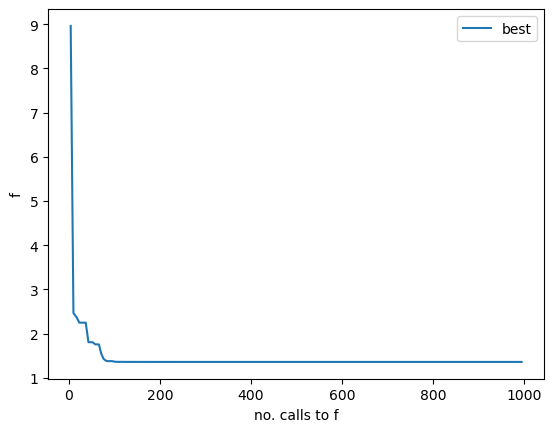

Best NN weights:
 [array([[1.02077735, 2.02616303, 2.97035538]])]


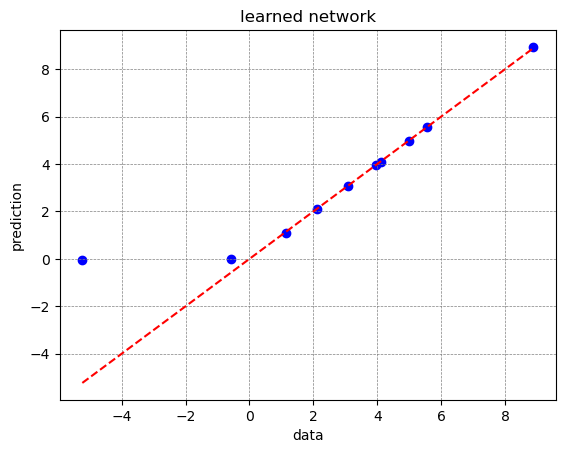

In [16]:
# reporting
# report optimization convergence
print_rec(res=res, fun=neural_network_cost, dim=len(res["x_best"]), 
          LB=LB, UB=UB , printlevel=printlevel, logscale = False)
# look at the network learned
weights_best = vector_to_weights(res["x_best"],used_network_structure) # extract weights of best network found
print("Best NN weights:\n",weights_best)
predicted_output = forward_propagation(used_data["data"],weights_best,used_activation)
plt.scatter(used_data["target"], predicted_output, label='pred vs. data', color='blue')
min_value = used_data["target"].min()
max_value = used_data["target"].max()
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='')
plt.xlabel('data')
plt.ylabel('prediction')
plt.title('learned network')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

### <span style="color:red">Question 4: make your own network for regression</span>

3. Generate 100 data points with the sphere function in 2 dimensions.
4. Create a network with 2 inputs, 5 ReLU neurons in the hidden layer, and 1 output.
5. Learn it on the quadratic data points you generated. Plot some results, discuss them.

### <span style="color:red">Answer 4: make your own network for regression</span>

Your code, your explanations

# **THE END**